# Importy

In [9]:
!pip install numpy
!pip install matplotlib
!pip install -U scikit-learn
!pip install seaborn
!pip install pandas
!pip install scipy
!pip install joblib

In [24]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib

# Wczytanie danych

In [58]:
train_df = pd.read_csv('train_data.csv', sep=';')
test_df = pd.read_csv('test_data.csv', sep=';')

train_df = train_df[train_df['price'] <= 1000].copy()
test_df = test_df[test_df['price'] <= 1000].copy()

In [59]:
target = 'price'
X_train = train_df.drop(columns=[target, 'id'])
y_train = train_df[target]
X_test = test_df.drop(columns=[target, 'id'])
y_test = test_df[target]

In [60]:
# log dla lepszej stabilności
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_test)

# Model

In [61]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from math import radians, sin, cos, sqrt, atan2
import ast
from collections import Counter
import re

# klasy stworzone na podstawie notatnika data_analysis, który stworzyliśmy w procesie analizy danych
class BathroomsProcessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.bedrooms_median_ = X['bedrooms'].median()
        self.beds_median_ = X['beds'].median()
        self.bathrooms_num_median_ = None
        return self

    def transform(self, X):
        df = X.copy()
        df['bedrooms'] = df['bedrooms'].fillna(self.bedrooms_median_)
        df['beds'] = df['beds'].fillna(self.beds_median_)

        def normalize_half_bath(value):
            if pd.isna(value):
                return value
            value = value.strip().lower()
            if value == 'half-bath':
                return '0.5 bath'
            elif value == 'shared half-bath':
                return '0.5 shared bath'
            elif value == 'private half-bath':
                return '0.5 private bath'
            return value

        def extract_bathrooms_num(text):
            if pd.isna(text) or text == 'nan':
                return np.nan
            match = re.match(r'^(\d*\.?\d+)', text)
            if match:
                return float(match.group(1))
            return np.nan

        def extract_suffix(text):
            if pd.isna(text) or text == 'nan':
                return np.nan
            match = re.match(r'^\d*\.?\d+\s*(.*)$', text)
            if match:
                return match.group(1).strip()
            return np.nan

        def classify_bathroom_type(suffix):
            if pd.isna(suffix):
                return 'unknown'
            suffix = suffix.lower()
            if 'shared' in suffix:
                return 'shared'
            elif 'private' in suffix:
                return 'private'
            else:
                return 'unknown'

        df['bathrooms_text'] = df['bathrooms_text'].apply(normalize_half_bath)
        df['bathrooms_text_num'] = df['bathrooms_text'].apply(extract_bathrooms_num)
        df['bathrooms_suffix'] = df['bathrooms_text'].apply(extract_suffix)
        df['bathrooms_num_old'] = pd.to_numeric(df['bathrooms'], errors='coerce')
        df['bathrooms_num'] = df['bathrooms_text_num'].combine_first(df['bathrooms_num_old'])

        if self.bathrooms_num_median_ is None:
            self.bathrooms_num_median_ = df['bathrooms_num'].median()
        df['bathrooms_num'] = df['bathrooms_num'].fillna(self.bathrooms_num_median_)
        df['bathroom_type'] = df['bathrooms_suffix'].apply(classify_bathroom_type)

        df.drop(columns=['bathrooms', 'bathrooms_text', 'bathrooms_text_num', 'bathrooms_num_old', 'bathrooms_suffix'], inplace=True)
        return df

class AmenitiesProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=50):
        self.top_n = top_n

    def fit(self, X, y=None):
        all_amenities = Counter(item for amenities in X['amenities'] for item in ast.literal_eval(amenities))
        self.top_amenities_ = [item for item, _ in all_amenities.most_common(self.top_n)]
        return self

    def transform(self, X):
        df = X.copy()
        def has_amenity(amenities_str, amenity):
            amenities_list = ast.literal_eval(amenities_str)
            return int(amenity in amenities_list)

        for amenity in self.top_amenities_:
            df[f'amenity_{amenity}'] = df['amenities'].apply(lambda x: has_amenity(x, amenity))
        df.drop(columns=['amenities'], inplace=True)
        return df

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # zapamiętujemy wartości do skalowania (mean, std)
        self.latitude_mean_ = X['latitude'].mean()
        self.latitude_std_ = X['latitude'].std()
        self.longitude_mean_ = X['longitude'].mean()
        self.longitude_std_ = X['longitude'].std()
        self.amenity_cols_ = [col for col in X.columns if col.startswith("amenity_")]
        return self

    def transform(self, X):
        df = X.copy()
        df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0})
        df["bathrooms_per_guest"] = df["bathrooms_num"] / df["accommodates"].replace(0, np.nan)
        df["bedrooms_per_guest"] = df["bedrooms"] / df["accommodates"].replace(0, np.nan)
        df["beds_per_guest"] = df["beds"] / df["accommodates"].replace(0, np.nan)
        df["beds_per_bedroom"] = df["beds"] / df["bedrooms"].replace(0, np.nan)
        df["guests_per_bedroom"] = df["accommodates"] / df["bedrooms"].replace(0, np.nan)

        for col in ["bathrooms_per_guest", "bedrooms_per_guest", "beds_per_guest", "beds_per_bedroom", "guests_per_bedroom"]:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            q_low, q_high = df[col].quantile([0.01, 0.99])
            df[col] = df[col].clip(q_low, q_high).fillna(df[col].median())

        def haversine(lat1, lon1, lat2=41.3870, lon2=2.1701):
            R = 6371
            dlat = radians(lat2 - lat1)
            dlon = radians(lon2 - lon1)
            a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
            return R * 2 * atan2(sqrt(a), sqrt(1 - a))

        df['dist_to_center'] = df.apply(lambda row: haversine(row['latitude'], row['longitude']), axis=1)
        df['lat_scaled'] = (df['latitude'] - self.latitude_mean_) / self.latitude_std_
        df['lon_scaled'] = (df['longitude'] - self.longitude_mean_) / self.longitude_std_
        df['is_group_friendly'] = (df['accommodates'] >= 4).astype(int)
        df["num_amenities"] = df[self.amenity_cols_].sum(axis=1)
        df["has_tv_or_wifi"] = df[["amenity_TV", "amenity_Wifi"]].max(axis=1)
        df["is_suited_for_longterm"] = (
            df[["amenity_Washer", "amenity_Kitchen", "amenity_Dishes and silverware"]].sum(axis=1) >= 2
        ).astype(int)
        return df

class LocationClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=15, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state

    def fit(self, X, y=None):
        from sklearn.cluster import KMeans
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init='auto')
        self.kmeans_.fit(X[['latitude', 'longitude']])
        return self

    def transform(self, X):
        df = X.copy()
        df['location_cluster'] = self.kmeans_.predict(df[['latitude', 'longitude']])
        return df

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categorical_cols = ['property_type', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'bathroom_type']
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    def fit(self, X, y=None):
        self.encoder.fit(X[self.categorical_cols])
        return self

    def transform(self, X):
        df = X.copy()
        encoded = self.encoder.transform(df[self.categorical_cols])
        encoded_cols = self.encoder.get_feature_names_out(self.categorical_cols)
        encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
        df = pd.concat([df.drop(columns=self.categorical_cols), encoded_df], axis=1)
        return df

In [62]:
pre_pipeline = Pipeline(steps=[
    ('bathrooms', BathroomsProcessor()),
    ('amenities', AmenitiesProcessor()),
    ('location_cluster', LocationClusterer(n_clusters=15)),
    ('feature_engineering', FeatureEngineering()),
])

X_transformed = pre_pipeline.fit_transform(X_train)

numerical_features = X_transformed.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_transformed.select_dtypes(include=['object', 'bool']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_features),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

model_pipeline = Pipeline(steps=[
    ('preprocessing', pre_pipeline),
    ('column_processing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Trening

In [63]:
param_dist = {
    'regressor__n_estimators': randint(100, 400),
    'regressor__max_depth': randint(5, 30),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 5),
    'regressor__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train, y_train_log)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('bathrooms',
                                                               BathroomsProcessor()),
                                                              ('amenities',
                                                               AmenitiesProcessor()),
                                                              ('location_cluster',
                                                               LocationClusterer()),
                                                              ('feature_engineering',
                                                               FeatureEngineering())])),
                                             ('column_processing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strateg...
                                        'regressor__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bf07d30fb50>,
                                        'regressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bf07d124c10>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bf061d5d950>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [64]:
print("Najlepsze parametry:", random_search.best_params_)
print(f"Najlepszy MAE (log scale): {-random_search.best_score_:.4f}")

Najlepsze parametry: {'regressor__max_depth': 25, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 314}
Najlepszy MAE (log scale): 0.4247


Dopasowanie do danych treningowych:

In [65]:
y_pred_log = random_search.predict(X_train)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
r2 = r2_score(y_train, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

MAE: 36.47
RMSE: 89.44
R^2: 0.76


Widać, że model dopasował się dość dobrze do danych treningowych - dość wysoka wartość metryki R^2 na zbiorze treningowym dobrze to obrazuje.

## Ważność cech

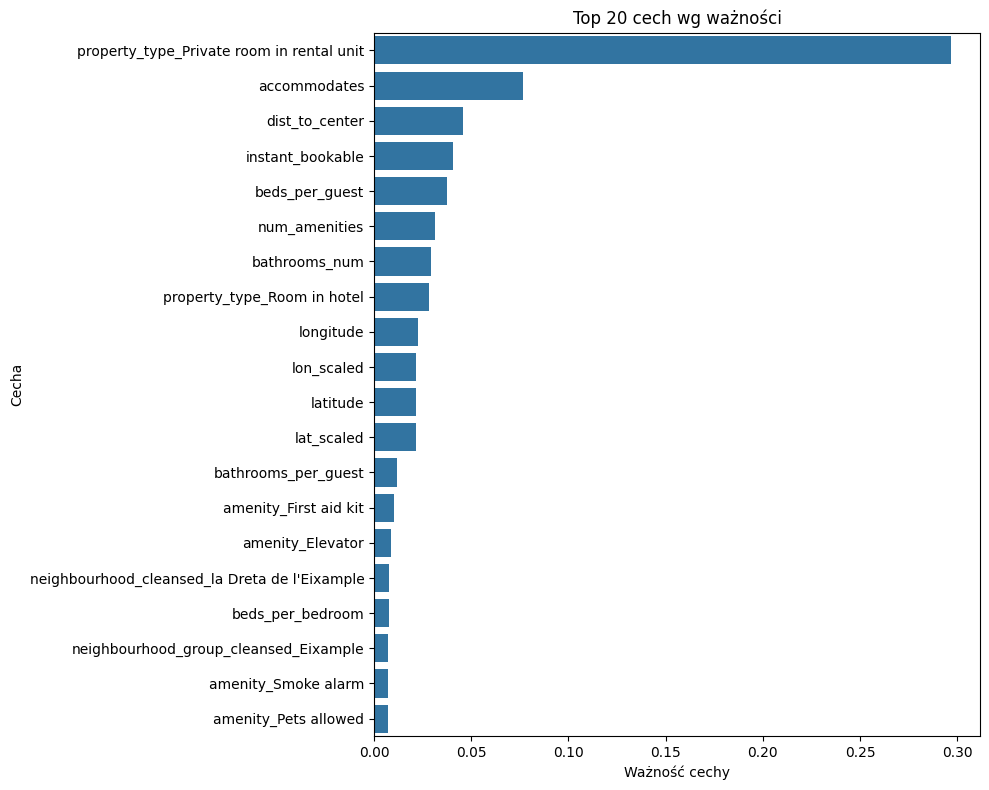

In [66]:
fitted_preprocessor = random_search.best_estimator_.named_steps['column_processing']
regressor = random_search.best_estimator_.named_steps['regressor']

numeric_features = fitted_preprocessor.transformers_[0][2]

categorical_pipeline = fitted_preprocessor.transformers_[1][1]
onehot = categorical_pipeline.named_steps['onehot']
categorical_input_features = fitted_preprocessor.transformers_[1][2]
categorical_features = onehot.get_feature_names_out(categorical_input_features)

all_features = list(numeric_features) + list(categorical_features)

importances = regressor.feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_features, 'importance': importances})
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(20), x='importance', y='feature')
plt.title("Top 20 cech wg ważności")
plt.xlabel("Ważność cechy")
plt.ylabel("Cecha")
plt.tight_layout()
plt.show()

Widać, że najważniejszymi cechami dla modelu są typ posiadłości (w tym wypadku prywatny pokój znacząco wpływa na cenę), dodatkowo w oczywisty sposób na cenę wpływa liczba możliwych do zakwaterowania w nim osób. Niżej znajduje się dystans do centrum (co jest dowodem, że warto było przeprowadzić feature engineering i dodać tą cechę do modelu), a także liczba udogodnień, łazienek oraz to, czy pokój jest możliwy do natychmiastowej rezerwacji.

# Ewaluacja

In [67]:
y_pred_log = random_search.predict(X_test)

y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

MAE: 73.01
RMSE: 147.91
R^2: 0.36


Na podstawie ewaluacji na zbiorze testowym można zauważyć, że model troche gorzej reprezentuje zbiór testowy - nie nauczył się odpowiednio generalizować. Wynik jest jednak (jak na dostępny zbiór danych) akceptowalny. Po wyniku R^2 już widać, że model jest lepszy niż model bazowy - który będąc średnią / medianą ma tę metrykę bliską 0.

## Wizualizacja predykcji

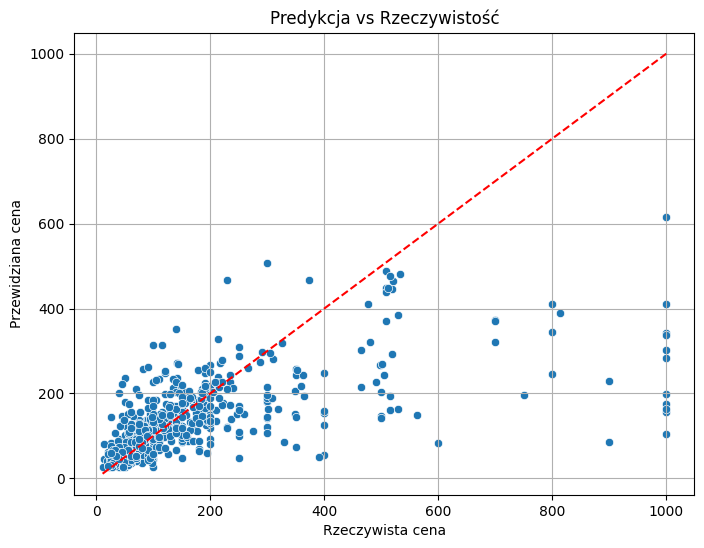

In [68]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Rzeczywista cena")
plt.ylabel("Przewidziana cena")
plt.title("Predykcja vs Rzeczywistość")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.grid(True)
plt.show()

Ten wykres dobrze pokazuje gdzie model się myli - ciężko jest mu poprawnie przewidzieć cenę dla dużych wartości - >800.
Wynika to z tego, że takich danych w zbiorze treningowym jest niewiele - model nie ma wystarczająco informacji, które mogą pomóc mu generować odpowiednią predykcję ceny.

## Wykres reszt

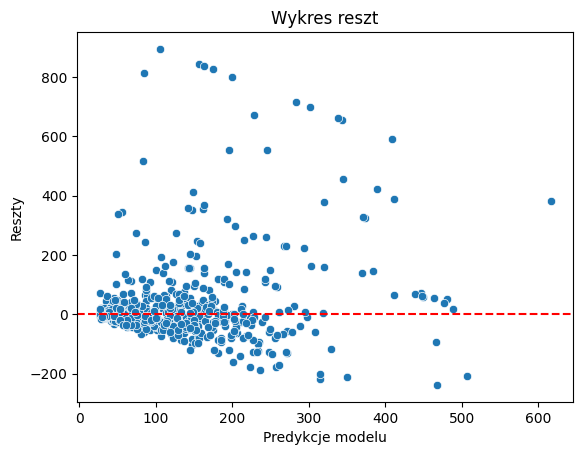

In [69]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predykcje modelu")
plt.ylabel("Reszty")
plt.title("Wykres reszt")
plt.show()

Na powyższym wykresie widać, że większość różnic modelu (między wartością predykowaną a realną) oscyluje w granicy akceptowalnie blisko 0 - model dobrze przewiduje te ceny. Zdarzają się jednak takie predykcje, dla których różnica jest wysoka - są to te przypadki, gdzie faktyczna cena jest duża (>800) - w zbiorze brakowało wystarczającej ilości danych dla tego segmentu cenowego.

## Rozkład błędów predykcji

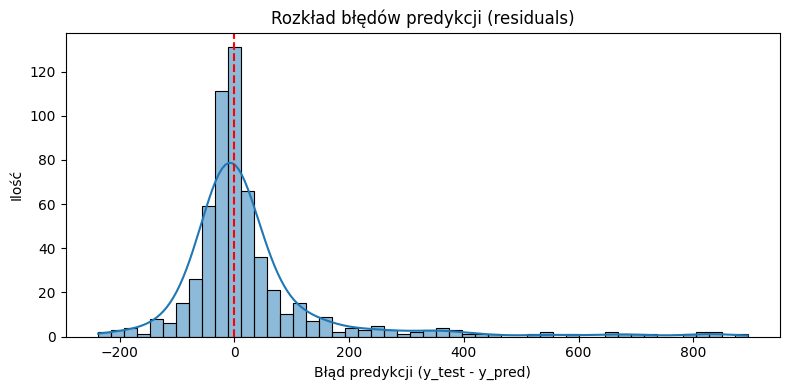

In [70]:
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Rozkład błędów predykcji (residuals)")
plt.xlabel("Błąd predykcji (y_test - y_pred)")
plt.ylabel("Ilość")
plt.tight_layout()
plt.show()

Powyższy wykres dokumentuje, że model działa stabilnie i dość dobrze. Najwięcej jest małych błędów predykcji - a im większy ten błąd tym rzadziej się on zdarza. To bardzo dobra oznaka. Widać, że model częściej niedoszacowuje cenę niż ją przeszacowuje (więcej jest różnic dodatnich niż ujemnych) - te sytuacje występują dla wcześniej już wspomnianych przypadków dużych cen (>800).

## Błąd w zalezności od faktycznej wartości

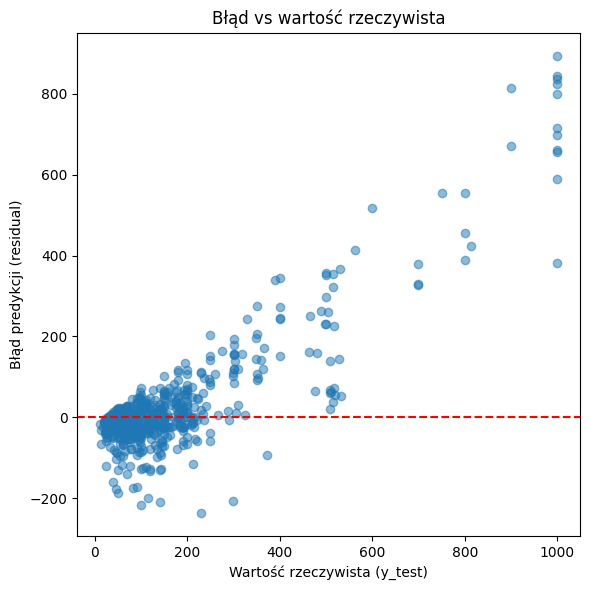

In [71]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Wartość rzeczywista (y_test)")
plt.ylabel("Błąd predykcji (residual)")
plt.title("Błąd vs wartość rzeczywista")
plt.tight_layout()
plt.show()

Wykres ten potwierdza poprzednie przypuszczenia - model najbardziej się myli na przypadkach, w których cena jest duża (800-1000).

## Największe pomyłki modelu

In [72]:
errors_df = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
    'error': residuals.abs()
})

top_errors = errors_df.sort_values(by='error', ascending=False).head(10)
print(top_errors)

       true        pred       error
457  1000.0  105.539488  894.460512
19   1000.0  155.857529  844.142471
384  1000.0  163.046916  836.953084
120  1000.0  174.849637  825.150363
244   900.0   85.006956  814.993044
154  1000.0  199.521675  800.478325
157  1000.0  283.275654  716.724346
456  1000.0  301.447694  698.552306
116   900.0  228.557685  671.442315
440   999.0  338.146384  660.853616


Największe pomyłki, bez zaskoczenia, są w przypadku, gdy prawdziwa cena oscyluje w granicy 1000. Model nie miał wystarczająco takich przypadków, stąd nie był w stanie odpowiednio się ich nauczyć.

# Zapis modelu

In [73]:
joblib.dump(random_search.best_estimator_, 'best_model.joblib')

['best_model.joblib']

# Model bazowy - porównanie

In [74]:
basic_preds = np.full(len(y_test), 100) # 100 to obliczona mediana cen

In [75]:
mae = mean_absolute_error(y_test, basic_preds)
rmse = np.sqrt(mean_squared_error(y_test, basic_preds))
r2 = r2_score(y_test, basic_preds)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

MAE: 107.44
RMSE: 196.10
R^2: -0.13


Widać, że podstawowy model radzi sobie zdecydowanie gorzej - wszystkie metryki mają dużo gorszą wartość niż dla finalnego modelu

## Rozkład błędów predykcji

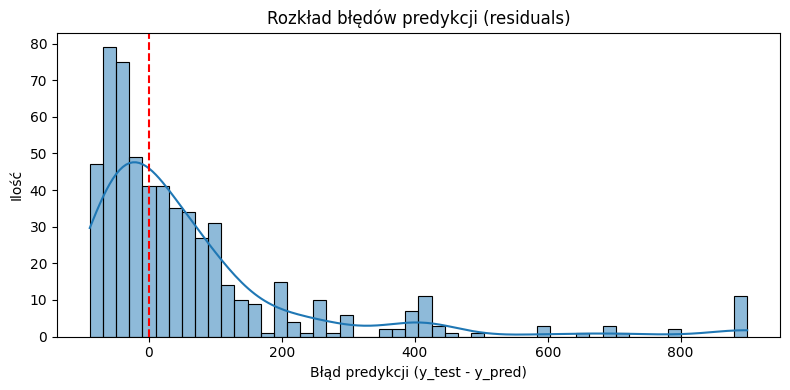

In [76]:
residuals = y_test - basic_preds
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Rozkład błędów predykcji (residuals)")
plt.xlabel("Błąd predykcji (y_test - y_pred)")
plt.ylabel("Ilość")
plt.tight_layout()
plt.show()

Rozkład błędów również pokazuje, że bazowy model niepoprawnie reprezentuje zbiór i (bez zaskoczenia) nie generuje dobrych predykcji.